In [42]:
# Imports
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipedia
import time
import pickle
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from operator import itemgetter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config import *
from transformers import *
from spectral_clustering import *
from pymagnitude import *
from predict import *
from pprint import pprint
from ast import literal_eval

In [43]:
# Loading dataframes and building graph
edge_list = pd.read_csv("ml-nlp-ai-ann-chatbot-ia-dataviz-dist2.tsv", sep = "\t")
df_node = pd.read_csv(DF_NODE_FILENAME)
df_node['keywords'] = df_node['keywords'].apply(literal_eval)
df_edge = pd.read_csv(DF_EDGE_FILENAME)
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)

In [44]:
# one article queries
query_1 = 'machine learning'
query_2 = 'data visualization'
query_3 = 'natural language processing'
query_4 = 'artificial intelligence'

# many articles queries
query_5 = 'data visualization,machine learning'
query_6 = 'artificial intelligence,natural language processing'
query_7 = 'social simulation,intelligent agent,chat bot'

# illustrating the pros of fasttext
query_8 = 'what is machine learning' # sentence like query
query_9 = 'money money money' # abba lyrics query
query_10 = 'automated learning' # non referenced article
query_11 = 'machine learning language processing' # referenced + non referenced articles

all_queries = [query_1,query_2,query_3,query_4,query_5,query_6,query_7,query_8,query_9,query_10,query_11]


cluster_1 = ['neural architecture search', 'hyperparameter optimization', 'model selection', 
             'self-tuning', 'automated machine learning']

cluster_2 = ['data visualization', 'data art', 'visual analytics', 'exploratory data analysis',
             'information visualization']

cluster_3 = ['machine learning', 'artificial intelligence', 'genetic algorithm', 'evolutionary computation',
             'reinforcement learning']

cluster_4 = ['natural language processing', 'latent dirichlet allocation', 'word2vec', 'speech processing',
             'information retrieval']

cluster_5 = ['convolutional neural network', 'deep learning', 'artificial neural network',
             'computational neuroscience', 'blue brain project']

cluster_6 = ['universal basic income', 'mincome', 'minimum wage', 'quatinga velho', 'job guarantee']

nodes_to_plot = cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6

# Node to vector representations

Algorithms:
- Node2Vec

In [45]:
node2vec_model = Word2Vec.load(NODE2VEC_FILENAME)

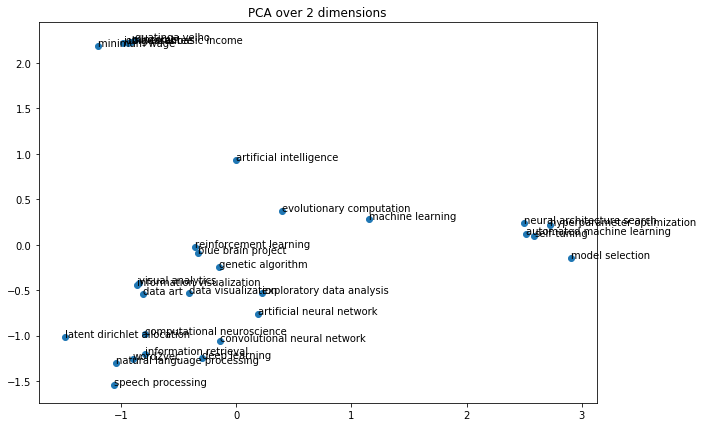

In [46]:
node_vectors = node2vec_model.wv[nodes_to_plot]
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/node2vec_pca')

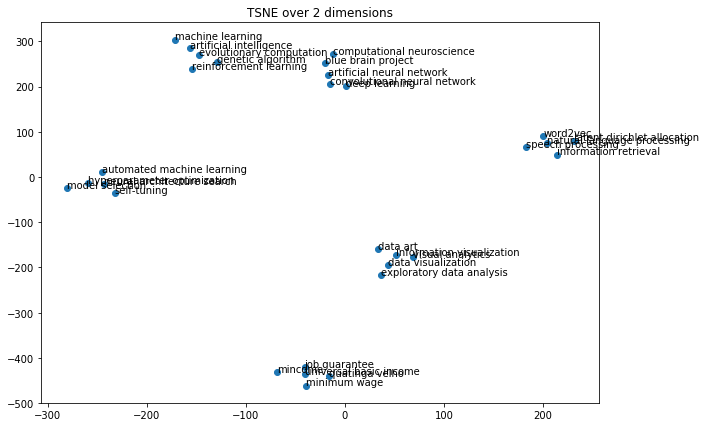

In [47]:
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/node2vec_tsne', projection_method=TSNE, perplexity=2)

## Spectral clustering on hyperlink graph

In [48]:
with open(SPECTRAL_CLUSTERING_FILENAME, 'rb') as handle:
    proj = pickle.load(handle)
    ordered_nodes = pickle.load(handle)
    name2idx_adjacency = pickle.load(handle)

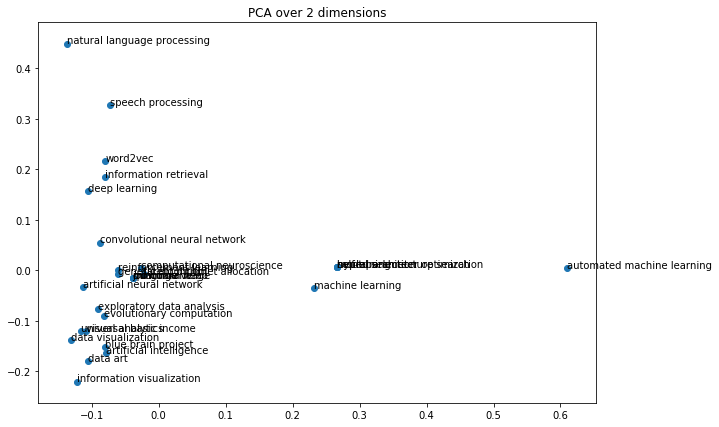

In [49]:
node_vectors = get_vectors_spectral(nodes_to_plot,proj,name2idx_adjacency)
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/spectral_pca')

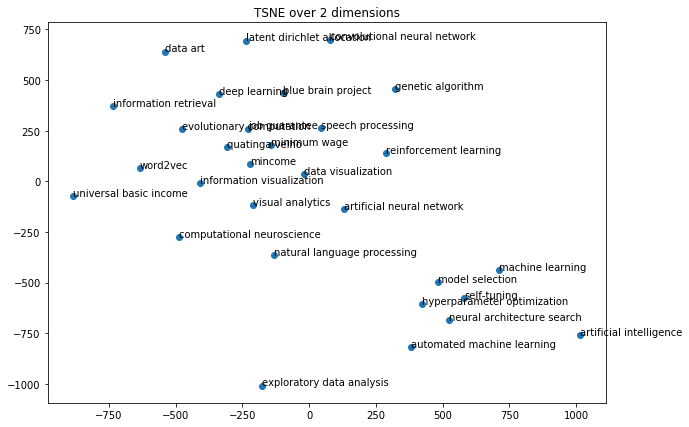

In [50]:
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/spectral_tsne', projection_method=TSNE, perplexity=3)

# Combining Node attributes and graph structure

- Obtain representations of keywords extracted from summaries as fasttext embeddings
- Perform walks and average embeddings

In [51]:
with open(FAST_MEAN_FILENAME, 'rb') as handle:
    walk_averaged_embeddings_dict_fastt = pickle.load(handle)

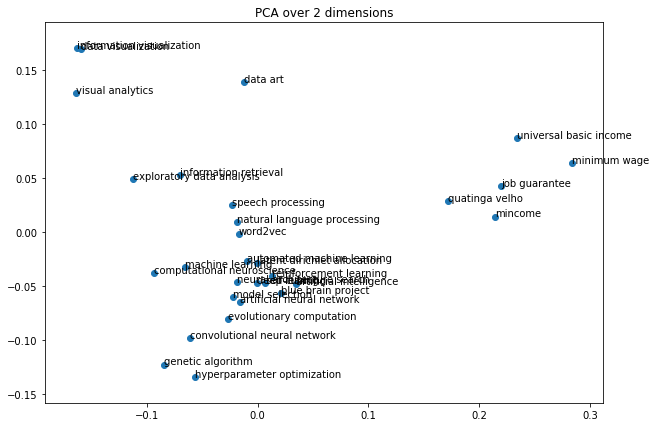

In [52]:
node_vectors = get_vectors_fasttext(nodes_to_plot,walk_averaged_embeddings_dict_fastt)
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/fastt_pca')

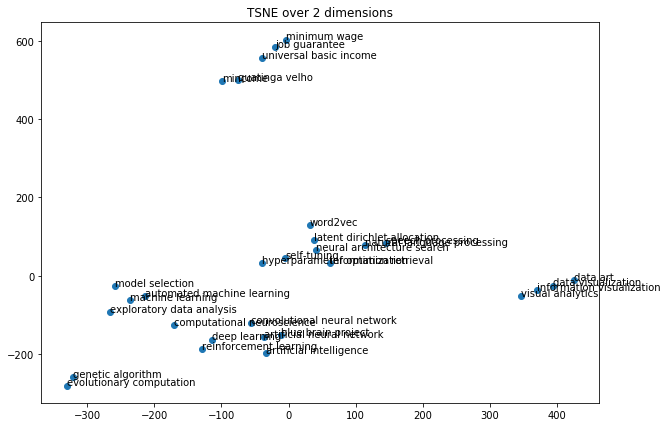

In [53]:
plot_projection(node_vectors, nodes_to_plot, 'clustering_evaluation/fastt_tsne', projection_method=TSNE, perplexity=2)

In [54]:
def all_queries_print(all_queries):
    for query in all_queries:
        print("\n----------\n")
        print(query)
        print("Node2Vec")
        pprint((query_answers_node2vec(query, node2vec_model, df_node, 10, return_idx=False)))
        print("Spectral")
        pprint(query_answers_spectral(query, proj, ordered_nodes, df_node, name2idx_adjacency, topn=10, return_idx=False))
        print("FastText")
        pprint((query_answers_fasttext(query,vectors,walk_averaged_embeddings_dict_fastt,df_node,topn=10, return_idx=False)))

In [55]:
%%capture cap --no-stderr
all_queries_print(all_queries)
with open('output.txt', 'w') as f:
    f.write(cap.stdout)